# Boris 2 setence converter

In [1]:
import pandas as pd
import os
import difflib
from unidecode import unidecode
from io import BytesIO
from collections import Counter
from datetime import datetime
import copy
import seaborn as sns
import math
import numpy as np
import ast

# Data - Transform

In [2]:
def dataTransform(seqfile, ethofile):
    '''
    input : the xlsx file containing the sequence extracted from Boris
    output : seqdf, focal, individual, output_name, output_index, ethodict
    seqfile = name of the boris file containing sequence
    ethofile = name of the file with unit code : unit name
    '''
    # Make sequence dataframe + pre-process
    seqdf = pd.read_excel(seqfile)
        
    # Add $ in front of each meta-unit
    seqdf = seqdf.replace("end", "$ - end")
    seqdf = seqdf.replace("pause", "$ - pause")
    seqdf = seqdf.replace("Entre dans le champs de vision", "$ - Entre dans le champs de vision")
    seqdf = seqdf.replace("Sort du champs de vision", "$ - Sort du champs de vision")
    
    focal = seqfile.split("\\")[-1].split('_')[1].split('.')[0]
    individual = seqfile.split("\\")[-1].split('_')[1].split('.')[1]
    output_name = seqfile.split('\\')[-1][:-5]
    output_index = seqfile.split('\\')[-1].split('_')[0]
    
    
    
    # Make ethogram dataframe + pre-process
    ethodf = pd.read_excel(ethofile)
    ethodf = ethodf[["Behavior code", "Behavior type", "Key"]]

    # Build dictionary of {units : code name}
    ethodict = {}
    for index, row in ethodf.iterrows(): # ethodf -> ['Behavior code', 'Behavior type', 'Key']
        row = ethodf.iloc[index]
        key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
        code = key + behavior_code_key
        unit = row['Behavior code']
        ethodict[unit] = code
    
    
    return seqdf, focal, individual, output_name, output_index, ethodict


## Overlap-less + Time-less

In [22]:
def boris2sentence(seqfile, ethofile, output_file, metaunits) :
    '''
        input : the xlsx file containing the sequence extracted from Boris
        output : a csv file with the obtained sentences as lines (each unit is a cell)
        seqfile = name of the boris file containing sequence
        ethofile = name of the file with unit code : unit name
        output_file = name of the csv file which will contain the output sequence
    '''
    seqdf, focal, individual, output_name, output_index, ethodict = dataTransform(seqfile, ethofile)
    
    #build sequence list
    seqlist = []
    for index, row in seqdf.iterrows(): # seqdf -> ['Time', 'Subject', 'Behavior', 'Behavior type']
        row = seqdf.iloc[index] 
        
        if not row['Behavior type'] == 'STOP':
            unit = row['Behavior']

            if(metaunits):
                #added unidecode to ensure that encoding differences don't produce mismatch errors
                if unidecode(row['Subject']) == unidecode(focal) : loc = "f"
                elif unidecode(row['Subject']) == unidecode(individual) : loc = "i"
                else : loc = "error" #and print("Mismatch between subject name and focal / individual")
                seqlist.append((loc, ethodict[unit]))
            else:
                if (ethodict[unit][-1] == '$'):
                    continue
                else:
                    #added unidecode to ensure that encoding differences don't produce mismatch errors
                    if unidecode(row['Subject']) == unidecode(focal) : loc = "f"
                    elif unidecode(row['Subject']) == unidecode(individual) : loc = "i"
                    else : loc = "error" #and print("Mismatch between subject name and focal / individual")
                    seqlist.append((loc, ethodict[unit]))

    #transform into csv
    seqlist.insert(0, output_name) 
    seqlist.insert(0, output_index)
    sentdf = pd.DataFrame([seqlist])
    #comment the following line for test run
    sentdf.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file))
    #print(f"succesfull with file : {seqfile}")
    return(sentdf)

### For 1 file

In [7]:
seqfile = r".\DATA\MATHILDE\2024\01_Mali.Angèle_23.01.23_matin_BI.xlsx" #05_Fana.Petoulette_23.01.23_matin_BI.xlsx
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
output_file = "Outputs/one_file_output.csv"

if os.path.exists(output_file):
  os.remove(output_file)
boris2sentence(seqfile, ethofile, output_file)

TypeError: boris2sentence() missing 1 required positional argument: 'metaunits'

### For batches of files

In [26]:
directory = r".\DATA\Merged Interactions" 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
output_file = "Outputs/metaunits_all_files_output.csv"

if os.path.exists(output_file):
    os.remove(output_file)
    
metaunits=True
for filename in os.listdir(directory):
    if not filename.startswith("."):
        sentdf = boris2sentence(os.path.join(directory, filename), ethofile, output_file, metaunits)

In [27]:
directory = r".\DATA\Merged Interactions" 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
output_file = "Outputs/no_metaunits_all_files_output.csv"
metaunits=False

if os.path.exists(output_file):
    os.remove(output_file)
for filename in os.listdir(directory):
    if not filename.startswith(".") :
        sentdf = boris2sentence(os.path.join(directory, filename), ethofile, output_file, metaunits)

In [28]:
csv_file_path = "Outputs/no_metaunits_all_files_output.csv"

max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names)


### Sequence length

In [29]:

output_file = "Outputs/sequence+len.csv"
len_sequence_df = sequence_df.copy()
len_sequence_df["sequence_len"] = len_sequence_df.iloc[:, 2:].count(axis=1)
len_sequence_df = len_sequence_df.drop(0)
if os.path.exists(output_file):
    os.remove(output_file)
len_sequence_df.to_csv(output_file)
len_sequence_df.head(5)


,id,File name,0,1,2,3,sequence_len
1,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"('i', 'cB')","('i', 'Ce')","('f', 'Ce')",NaN,3
2,2,02_Lips.Pipo_25.01.23_matin_UNI,"('f', 'ct')","('f', 'cr')","('f', 'Cg')",NaN,3
3,3,03_Bobo.Mako_26.01.23_matin_UNI,"('i', 'ca')","('i', 'cl')","('i', 'Cg')","('f', 'ct')",4
4,4,04_Angèle.Violette_26.01.23_matin_UNI,"('f', 'cK')","('f', 'ca')","('f', 'cq')","('f', 'Cg')",4
5,5,05_Bobo.Muse_30.01.23_matin_UNI,"('i', 'ca')","('i', 'cq')","('i', 'Cg')",NaN,3


### Length and Tokens

In [30]:
output_file_csv = "outputs/sequence+len+tokens.csv"
output_file_excel = "outputs/sequence+len+tokens.xlsx"

len_token_sequence_df = sequence_df.copy()

len_token_sequence_df = len_token_sequence_df.drop(0)
len_list, len_focal_list, len_indiv_list, token_focal_list, token_indiv_list, token_both_list, token_all_list = [],[],[],[],[],[],[]

for id, row in len_token_sequence_df.iterrows() :
    # count = 0
    len_f, len_i, token_f, token_i, token_a, token_both = [], [], [], [], [], []
    
    for elem in row[2:-2] :
        if not pd.isna(elem): 
            # count+=1
            if elem.split("'")[3] not in token_both :
                token_both.append(elem.split("'")[3])
            if elem not in token_a: #.split("'")[3]
                token_a.append(elem)
            if elem.split("'")[1]=='f' :
                len_f.append(elem)
                if elem.split("'")[3] not in token_f :
                    token_f.append(elem.split("'")[3])
            if elem.split("'")[1]=='i' :
                len_i.append(elem)
                if elem.split("'")[3] not in token_i :
                    token_i.append(elem.split("'")[3])
    #print(len(token_a), len(token_i), len(token_f))

    # len_list.append(count)
    len_focal_list.append(len(len_f))
    len_indiv_list.append(len(len_i))
    token_all_list.append(len(token_a))
    token_both_list.append(len(token_both))
    token_focal_list.append(len(token_f))
    token_indiv_list.append(len(token_i))

# len_token_sequence_df["sequence_len"] = len_list
len_token_sequence_df["sequence_len"] = len_token_sequence_df.iloc[:, 2:].count(axis=1)
len_token_sequence_df["focal_sequence_len"] = len_focal_list
len_token_sequence_df["receiver_sequence_len"] = len_indiv_list
len_token_sequence_df["nb_tokens_all"] = token_all_list
len_token_sequence_df["nb_tokens_focal"] = token_focal_list
len_token_sequence_df["nb_tokens_receiver"] = token_indiv_list
len_token_sequence_df["nb_tokens_both_indiv"] = token_both_list

if os.path.exists(output_file_csv):
    os.remove(output_file_csv)
if os.path.exists(output_file_excel):
    os.remove(output_file_excel)
    
len_token_sequence_df['id'] = len_token_sequence_df['id'].astype(int)
len_token_sequence_df = len_token_sequence_df.sort_values(by='id')
    
len_token_sequence_df.to_csv(output_file_csv)
len_token_sequence_df.to_excel(output_file_excel, index=False)
len_token_sequence_df.head()

,id,File name,0,1,2,3,sequence_len,focal_sequence_len,receiver_sequence_len,nb_tokens_all,nb_tokens_focal,nb_tokens_receiver,nb_tokens_both_indiv
1,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"('i', 'cB')","('i', 'Ce')","('f', 'Ce')",NaN,3,0,2,2,0,2,2
2,2,02_Lips.Pipo_25.01.23_matin_UNI,"('f', 'ct')","('f', 'cr')","('f', 'Cg')",NaN,3,2,0,2,2,0,2
3,3,03_Bobo.Mako_26.01.23_matin_UNI,"('i', 'ca')","('i', 'cl')","('i', 'Cg')","('f', 'ct')",4,0,2,2,0,2,2
4,4,04_Angèle.Violette_26.01.23_matin_UNI,"('f', 'cK')","('f', 'ca')","('f', 'cq')","('f', 'Cg')",4,2,0,2,2,0,2
5,5,05_Bobo.Muse_30.01.23_matin_UNI,"('i', 'ca')","('i', 'cq')","('i', 'Cg')",NaN,3,0,2,2,0,2,2


## Adding individuals informations

In [31]:
def boris2sentence_overlap(seqfile, ethofile, output_file) :
    #print(f"processing file : {seqfile}")
    '''
        input : the xlsx file containing the sequence extracted from Boris
        output : a csv file with the obtained sentences as lines (each unit is a cell)
        seqfile = name of the boris file containing sequence
        ethofile = name of the file with unit code : unit name
        output_file = name of the csv file which will contain the output sequence
    '''
    
    seqdf, focal, individual, output_name, output_index, ethodict = dataTransform(seqfile, ethofile)

    #build sequence list
    seqlist = []
    temp = []
        
    actions = {
        'f': {},
        'i': {},
    }
    end = None
    for index, row in seqdf.iterrows() :
        row = seqdf.iloc[index]
        subject = unidecode(row['Subject'])
        unit = row['Behavior']
        
        if subject == unidecode(focal) : loc = "f"
        elif subject == unidecode(individual) : loc = "i"
        else: loc = "error"

        if ethodict[unit][-1] == '$':
            continue
        
        if row['Behavior type'] == 'START' or row['Behavior type'] == 'POINT':
            start = row['Time'] 
            temp.append((loc, ethodict[unit]))
            seqlist.append([item for item in temp])
            if row['Behavior type'] == 'POINT':
                temp.pop(-1)
                end = None
                seqlist.append([item for item in temp]) # added later
        elif row['Behavior type'] == "STOP" :
            end = row['Time'] 
            temp.remove((loc, ethodict[unit]))
            seqlist.append([item for item in temp]) # added later
            
        if loc == "error":
            print(seqfile, "error")
        
        if loc != "error":
            unit_key = ethodict[unit]
            
            if unit_key in actions[loc]:
                if row['Behavior type'] in ['START', 'POINT']:
                    actions[loc][unit_key].append((start, end))
                elif row['Behavior type'] == 'STOP':
                    actions[loc][unit_key][-1] = (actions[loc][unit_key][-1][0], end)
            else:
                actions[loc][unit_key] = [(start, end)]
                
    # print(actions)
    #transform into csv
    seqlist.insert(0, output_name)
    seqlist.insert(0, output_index.split("/")[2])
    seqlist.pop()
    sentdf = pd.DataFrame([seqlist])
    sentdf.to_csv(output_file, mode='a', index=False, header=False)
    
    return sentdf, actions

In [32]:
directory = "DATA/Merged Interactions/"
ethofile = "DATA/Ethogram_Baboons_2024.xlsx"
output_file = "Outputs/overlap_test.csv"

actions = []

if os.path.exists(output_file):
    os.remove(output_file)
for filename in os.listdir(directory):
    # checking if it is a file
    if not filename.startswith(".") :
        sentdf, actions_file = boris2sentence_overlap(os.path.join(directory, filename), ethofile, output_file)
        actions.append(actions_file)




#### Actions to Dataframe

In [37]:
sequences_overlap_file = "Outputs/overlap_test.csv"
max_columns = 0
with open(sequences_overlap_file, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns+15)]
overlap_csv = pd.read_csv(sequences_overlap_file, names=column_names)


In [38]:
action_df = pd.DataFrame(actions)
action_df.shape[0]
action_df['Index'], action_df['File name'] = overlap_csv['id'], overlap_csv['File name'].apply(lambda x: x.split('/')[2])
action_df = action_df[['Index', 'File name','f','i']]
action_df['Index'] = action_df['Index'].astype(int)
action_df = action_df.sort_values(by='Index')

action_df.to_excel("Outputs/actions.xlsx", index=False)


In [39]:
action_df = pd.read_excel("Outputs/actions.xlsx")
action_df.head(5)


,Index,File name,f,i
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"{'Ce': [(23.955, 32.655)]}","{'cB': [(22.292, None)], 'Ce': [(22.855, 33.17..."
1,2,02_Lips.Pipo_25.01.23_matin_UNI,"{'ct': [(321.431, None)], 'cr': [(322.307, Non...",{}
2,3,03_Bobo.Mako_26.01.23_matin_UNI,"{'ct': [(31.224, None)]}","{'ca': [(28.276, 29.876)], 'cl': [(29.876, Non..."
3,4,04_Angèle.Violette_26.01.23_matin_UNI,"{'cK': [(267.951, None)], 'ca': [(267.951, 269...",{}
4,5,05_Bobo.Muse_30.01.23_matin_UNI,{},"{'ca': [(125.235, 127.1)], 'cq': [(127.1, None..."


In [40]:
overlap_csv.head(5)

,id,File name,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,1,DATA/Merged Interactions/01_Lomé.Nekketsu_23.0...,"[('i', 'cB')]",[],"[('i', 'Ce')]","[('i', 'Ce'), ('f', 'Ce')]","[('i', 'Ce')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,DATA/Merged Interactions/02_Lips.Pipo_25.01.23...,"[('f', 'ct')]",[],"[('f', 'cr')]",[],"[('f', 'Cg')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DATA/Merged Interactions/03_Bobo.Mako_26.01.23...,"[('i', 'ca')]",[],"[('i', 'cl')]",[],"[('i', 'Cg')]","[('i', 'Cg'), ('f', 'ct')]","[('i', 'Cg')]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,DATA/Merged Interactions/04_Angèle.Violette_26...,"[('f', 'cK')]",[],"[('f', 'ca')]",[],"[('f', 'cq')]",[],"[('f', 'Cg')]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,DATA/Merged Interactions/05_Bobo.Muse_30.01.23...,"[('i', 'ca')]",[],"[('i', 'cq')]",[],"[('i', 'Cg')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Overlap counter

In [43]:

def overlap_counter(sequences_overlap_file, to_csv=True) :

    max_columns = 0
    with open(sequences_overlap_file, 'r') as file:
        for line in file:
            num_columns = len(line.split(','))
            max_columns = max(max_columns, num_columns)
    column_names = ['id', 'File name'] + [i for i in range(max_columns - 1)]
    dataframe = pd.read_csv(sequences_overlap_file, names=column_names)
    #print(overlap_df)

    len_list, overlap_list, len_list_f, len_list_i, overlap_list_inter, overlap_list_intra_f, overlap_list_intra_i, overlap_list_intra = [], [], [], [], [], [], [], []

    for id, row in dataframe.iterrows() :
        count = count_overlap = count_f = count_i = count_inter = count_intra_f = count_intra_i = count_intra = 0
        for elem in row[2:]:
            if not pd.isna(elem) :
                elem = eval(elem)
                #total len :
                count+=1
                #focal len :
                if "f" in [unit[0] for unit in elem] :
                    count_f+=1
                    #intra individual overlap :
                    if "i" in [unit[0] for unit in elem] : count_inter+=1
                    if [unit[0] for unit in elem].count("f") > 1 : count_intra_f+=1
                #indiv len :
                if "i" in [unit[0] for unit in elem] :
                    count_i+=1
                    if [unit[0] for unit in elem].count("i") > 1 : count_intra_i+=1
                #overlap len:
                if len(elem)>1 : count_overlap+=1
                #overlap intra total : 
                if [unit[0] for unit in elem].count("i") > 1 or [unit[0] for unit in elem].count("f") > 1 : count_intra+=1

        len_list.append(count)
        len_list_f.append(count_f)
        len_list_i.append(count_i)
        overlap_list.append(count_overlap)
        overlap_list_inter.append(count_inter)
        overlap_list_intra_f.append(count_intra_f)
        overlap_list_intra_i.append(count_intra_i)
        overlap_list_intra.append(count_intra)

    indexes = dataframe[dataframe.columns[0]].values.tolist()

    #percentages : 
    percent_f = [(len_list_f[i]/len_list[i]) for i in range(len(len_list))]
    percent_i = [(len_list_i[i]/len_list[i]) for i in range(len(len_list))]
    percent_overlap = [(overlap_list[i]/len_list[i]) for i in range(len(len_list))]
    percent_inter_overlap = [(overlap_list_inter[i]/len_list[i]) for i in range(len(len_list))] 
    percent_intra_f_overlap =  [(overlap_list_intra_f[i]/len_list[i]) for i in range(len(len_list))]
    percent_intra_i_overlap =  [(overlap_list_intra_i[i]/len_list[i]) for i in range(len(len_list))]
    percent_intra_overlap = [(overlap_list_intra[i]/len_list[i]) for i in range(len(len_list))]


    new_df = pd.DataFrame({'index': indexes,
        "File name": dataframe['File name'],
        "Focal": dataframe['File name'].apply(lambda x: x.split("/")[2].split("_")[1].split(".")[0]),
        "Individual": dataframe['File name'].apply(lambda x: x.split("/")[2].split("_")[1].split(".")[1]),
        "Total States": len_list,
        "Len States Focal": len_list_f,
        "Percentage of Focal States": percent_f,
        "Len States Individual": len_list_i,
        "Percentage of Individual States": percent_i,
        "Number Overlaps" : overlap_list,
        "Percentage of Overlap" : percent_overlap,
        "nb inter-indiv overlap" : overlap_list_inter,
        "percentage of inter-indiv overlap" : percent_inter_overlap,
        "nb intra overlap focal": overlap_list_intra_f,
        "percentage of intra overlap focal": percent_intra_f_overlap,
        "nb intra overlap other": overlap_list_intra_i,
        "percentage of intra overlap other": percent_intra_i_overlap,
        "nb intra-indiv overlap for both": overlap_list_intra,
        "percentage of intra overlap for both": percent_intra_overlap,
        })

    output_file = "Outputs/overlap_count.csv"
    if os.path.exists(output_file):
        os.remove(output_file)
    new_df.to_csv(output_file)
    return new_df


In [44]:
overlap_file = "Outputs/overlap_test.csv"

overlap_counter_df = overlap_counter(overlap_file)
overlap_counter_df['index'] = overlap_counter_df['index'].astype(int)
overlap_counter_df = overlap_counter_df.sort_values(by='index')


output_file = "Outputs/overlap_counter.xlsx"
if os.path.exists(output_file):
    os.remove(output_file)

overlap_counter_df.to_excel(output_file, index=False)



# Succession counter

In [30]:
def turntaking_counter(sequences_overlap_file, to_csv=True):

    column_names = [i for i in range(0, 87)]
    dataframe = pd.read_csv(sequences_overlap_file, names=column_names)
    #print(overlap_df)

    succession_list, overlap_list, turntaking_list, len_list = [], [], [], []


    for id, row in dataframe.iterrows() :
        succession = 0
        inter_overlap = 0
        truntake = 0
        count = 0
        ex_indiv = "ex_overlap"
        for elem in row[2:] :
            if not pd.isna(elem) :
                count+=1
                elem = eval(elem)
                new_indiv = elem[0][0]
                if ex_indiv == "ex_overlap" :
                    if "f" in [unit[0] for unit in elem] and "i" in [unit[0] for unit in elem] :
                        inter_overlap+=1
                        ex_indiv = "ex_overlap"
                    else : ex_indiv = new_indiv
                elif "f" in [unit[0] for unit in elem] and "i" in [unit[0] for unit in elem] :
                    inter_overlap+=1
                    ex_indiv = "ex_overlap"
                else: 
                    if new_indiv == ex_indiv :
                        succession+=1
                    elif new_indiv!=ex_indiv :
                        truntake+=1
                    ex_indiv=new_indiv
        len_list.append(count)
        succession_list.append(succession)
        overlap_list.append(inter_overlap)
        turntaking_list.append(truntake)
        #print(f"succession : {succession}")
        #print(f"turntake : {truntake}")
        #print(f"inter overlap : {inter_overlap}")


    indexes = dataframe[dataframe.columns[0]].values.tolist()

    percent_succession = [(succession_list[i]/len_list[i]) for i in range(len(len_list))]
    percent_overlap = [(overlap_list[i]/len_list[i]) for i in range(len(len_list))]
    percent_turntaking = [(turntaking_list[i]/len_list[i]) for i in range(len(len_list))]


    new_df = pd.DataFrame({'index': indexes,
        "percentage of succession": percent_succession,
        "percentage of inter overlap": percent_overlap,
        "percentage of turn taking": percent_turntaking}
    )

    if to_csv :
        new_df.to_csv("Outputs/turn_taking_count.csv")
    return new_df



In [31]:
sequences_overlap_file = 'Outputs/overlap_test.csv'
turntaking_counter(sequences_overlap_file)

,index,percentage of succession,percentage of inter overlap,percentage of turn taking
0,DATA/Merged Interactions/01,0.050000,0.650000,0.100000
1,DATA/Merged Interactions/02,0.375000,0.375000,0.062500
2,DATA/Merged Interactions/03,0.214286,0.357143,0.142857
3,DATA/Merged Interactions/04,0.312500,0.312500,0.250000
4,DATA/Merged Interactions/05,0.444444,0.222222,0.222222
...,...,...,...,...
383,DATA/Merged Interactions/95,0.555556,0.111111,0.111111
384,DATA/Merged Interactions/96,0.529412,0.058824,0.294118
385,DATA/Merged Interactions/97,0.444444,0.000000,0.444444
386,DATA/Merged Interactions/98,0.153846,0.384615,0.153846


# Time counters

In [45]:
def boris2time(seqfile, output_file) :
    #print(f"processing file : {seqfile}")
    '''
    input : the xlsx file containing the sequence extracted from Boris
    output : a csv file with sequence index : time
    seqfile = name of the boris file containing sequence (with 15 lines on top)
    output_file = name of the csv file 
    mathilde = if the file was coded by mathilde (True) or lise (False)
    '''
    #make sequence dataframe + pre-process
    seqdf = pd.read_excel(seqfile)
    #select the right titles of the columns
    seqdf = seqdf[["Time"]]
    

    output_index = seqfile.split('/')[-1].split('_')[0]

    start = float(seqdf.loc[seqdf.index[1]]["Time"])
    end = float(seqdf.loc[seqdf.index[-1]]["Time"])

    timedf = pd.DataFrame([[output_index, start, end, end-start]], columns=["index", "start", "end", "length"], )
    timedf.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file)) # just write the header in the first iteration

    return timedf

In [46]:
directory = "./DATA/Merged Interactions/" 
output_file = "Outputs/durées.csv"

if os.path.exists(output_file):
  os.remove(output_file)
for filename in os.listdir(directory):
    # checking if it is a file
    if not filename.startswith(".") :
        sentdf = boris2time(os.path.join(directory, filename), output_file)


# Unit counter

In [48]:
csv_file_path = "Outputs/no_metaunits_all_files_output.csv"

#build dictionnary of units from ethogram : 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
ethodf = pd.read_excel(ethofile)
ethodf = ethodf[["Behavior code", "Behavior type", "Key"]]

#build dictionary of {units : code name}
unit_dict = {}
for index, row in ethodf.iterrows() :
    row = ethodf.iloc[index]
    key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
    code = key + behavior_code_key
    unit = row['Behavior code']
    unit_dict[code] = 0

max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]
dataframe = pd.read_csv(csv_file_path, names=column_names).drop(0)

indiv_dict = {}
for index, row in dataframe.iterrows() :
    row = dataframe.iloc[index-1]
    focal, indiv = unidecode(row['File name'].split("_")[1].split(".")[0]), unidecode(row['File name'].split("_")[1].split(".")[1])
    indiv_dict[focal] = copy.deepcopy(unit_dict)
    indiv_dict[indiv] = copy.deepcopy(unit_dict)

#fill :
#iterate over each sequence. f = focal, i = indiv. count for each 
for index, row in dataframe.iterrows() :
    focal, indiv = unidecode(row['File name'].split("_")[1].split(".")[0]), unidecode(row['File name'].split("_")[1].split(".")[1])
    for elem in row[2:]:
        if not pd.isna(elem) :
            elem = eval(elem)
            if elem[0] == "f" :
                indiv_dict[focal][elem[1]] += 1
            elif elem[0] == "i" :
                indiv_dict[indiv][elem[1]] += 1


new_df = pd.DataFrame.from_dict(indiv_dict).T
new_df['Total number'] = new_df.sum(axis=1)
new_df['Total units'] = new_df.astype(bool).sum(axis=1)-1


output_file = "Outputs/unit_count.csv"
if os.path.exists(output_file):
    os.remove(output_file)
new_df.to_csv(output_file)
new_df.head()


,D$,S$,s$,z$,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc,Total number,Total units
Lome,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
Nekketsu,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,5,5
Lips,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,3
Pipo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
Bobo,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,1


# Tokens - Length - Speed of emission - Duration

In [49]:
tokens_len_df = pd.read_csv("Outputs/sequence+len+tokens.csv")
tokens_len_df = tokens_len_df[['id', 'nb_tokens_all', 'sequence_len']]

duration_df = pd.read_csv("Outputs/durées.csv")[['index', 'length']]

merged_df = tokens_len_df.merge(duration_df, left_on='id', right_on='index', how='inner').drop(columns=['index'])
merged_df = merged_df.merge(sequence_df[['id', 'File name']], on='id', how='inner')
  
merged_df['Speed of emission'] = merged_df['sequence_len']/merged_df['length']

merged_df['Focal'] = merged_df['File name'].apply(lambda x: x.split("\\")[-1].split('_')[1].split('.')[0])
merged_df['Individual'] = merged_df['File name'].apply(lambda x: x.split("\\")[-1].split('_')[1].split('.')[1])

merged_df = merged_df[['id', 'File name','Focal','Individual', 'sequence_len', 'nb_tokens_all', 'length', 'Speed of emission']]
merged_df = merged_df.rename(columns={'length':'duration'})
merged_df['id'] = merged_df['id'].astype(int)
merged_df = merged_df.sort_values(by='id')

In [50]:
merged_df_output = "Outputs/len+tokens+time+se.xlsx"
merged_df.to_excel(merged_df_output, index=False)

In [51]:
merged_df_output = "./Outputs/len+tokens+time+se.xlsx"
merged_df = pd.read_excel(merged_df_output)

In [52]:
merged_df.to_excel(merged_df_output, index=False)

# Overlap + Action per second + Mean

In [53]:
action_df_path = "Outputs/actions.xlsx"
action_df = pd.read_excel(action_df_path)

In [54]:
action_df.head()

,Index,File name,f,i
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"{'Ce': [(23.955, 32.655)]}","{'cB': [(22.292, None)], 'Ce': [(22.855, 33.17..."
1,2,02_Lips.Pipo_25.01.23_matin_UNI,"{'ct': [(321.431, None)], 'cr': [(322.307, Non...",{}
2,3,03_Bobo.Mako_26.01.23_matin_UNI,"{'ct': [(31.224, None)]}","{'ca': [(28.276, 29.876)], 'cl': [(29.876, Non..."
3,4,04_Angèle.Violette_26.01.23_matin_UNI,"{'cK': [(267.951, None)], 'ca': [(267.951, 269...",{}
4,5,05_Bobo.Muse_30.01.23_matin_UNI,{},"{'ca': [(125.235, 127.1)], 'cq': [(127.1, None..."


In [55]:

f_i_actions = action_df[['f','i']]

def calculate_start_end(my_dict):
    # Check if the dictionary is not empty before accessing values
    if my_dict:
        start = min(action[0] if action[0] is not None else 0 for unit_actions in my_dict.values() for action in unit_actions)
        end = max(action[1] if action[1] is not None else action[0] for unit_actions in my_dict.values() for action in unit_actions)
    else:
        start = end = np.nan
    
    return start, end
start_actions_array = []
end_actions_array = []

def nan_aware_min(a, b):
    if np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return min(a, b)

def nan_aware_max(a, b):
    if np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return max(a, b)

for i, row in f_i_actions.iterrows():
    f_dict = ast.literal_eval(row['f']) 
    i_dict = ast.literal_eval(row['i'])

    start_f, end_f = calculate_start_end(f_dict)
    start_i, end_i = calculate_start_end(i_dict)

    start_total = nan_aware_min(start_f, start_i)
    end_total = nan_aware_max(end_f, end_i)

    start_actions_array.append(start_total)
    end_actions_array.append(end_total)




final_action_df = action_df.copy()[['Index', 'File name']]
final_action_df['Start'] = start_actions_array
final_action_df['End'] = end_actions_array
final_action_df['Duration'] = final_action_df['End'] - final_action_df['Start']
final_action_df.head(10)


,Index,File name,Start,End,Duration
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887
1,2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049
2,3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297
3,4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124
4,5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515
5,6,06_Bobo.Muse_30.01.23_aprem_UNI,54.698,67.287,12.589
6,7,07_Fana.Petoulette_31.01.23_matin_UNI,1.501,15.414,13.913
7,8,08_Petoulette.Pipo_01.02.23_matin.UNI,97.151,109.543,12.392
8,9,09_Nekketsu.Feya_15.03.23_aprem_UNI,259.452,271.070,11.618
9,10,10_Fana.Mali_15.03.23_aprem_UNI,83.574,96.747,13.173


# Action 0.5s

In [56]:

amount_columns = np.arange(0, math.ceil(max(final_action_df['Duration'])+5), 0.5)
for i in amount_columns:
    final_action_df['S' + str(i)] = ""

In [57]:
def process_dict(unit_actions, start_actions, i):
    result_dict = {}
    for unit_key, actions in unit_actions.items():
        result_actions = []
        for action in actions:
            # print(start_actions)
            action_start = round(action[0] - start_actions[i], 1)
            if action[1] is None:
                action_end = action_start
            else:
                action_end = round(action[1] - start_actions[i], 1)

            action_duration = round(action_end - action_start, 1)
            # print(action,"as",action_start, start_actions[i], "ae", action_end)
            action_duration_counting_half = np.arange(action_start, action_end + 0.5, 0.5)

            for k in range(len(action_duration_counting_half)):
                action_duration_counting_half[k] = round(action_duration_counting_half[k], 2)
                decimal = int(str(action_duration_counting_half[k]).split('.')[1])
                if decimal > 5:
                    action_duration_counting_half[k] += (10 - decimal) * 0.1
                if decimal < 5 and decimal != 0:
                    action_duration_counting_half[k] += (5 - decimal) * 0.1

            for j in action_duration_counting_half:
                column_name = 'S' + str(j)
                result_actions.append(column_name)
        result_dict[unit_key] = result_actions
    return result_dict

def update_dataframe(dataframe, result_dict, i, i_or_f):
    for unit_key, actions in result_dict.items():
        for action in actions:
            if dataframe.at[i, action] == '':
                dataframe.at[i, action] = []
            dataframe.at[i, action].append(i_or_f+"_"+unit_key)


for i, row in f_i_actions.iterrows():
    f_dict = ast.literal_eval(row['f'])
    result_f_dict = process_dict(f_dict, start_actions_array, i)
    update_dataframe(final_action_df, result_f_dict, i, "f")


for i, row in f_i_actions.iterrows():
    i_dict = ast.literal_eval(row['i'])
    result_i_dict = process_dict(i_dict, start_actions_array, i)
    update_dataframe(final_action_df, result_i_dict, i, "i")


In [58]:
action_per_second_output = "Outputs/actions_per_second.xlsx"
# final_action_df['id'] = final_action_df['id'].astype(int)
# final_action_df = final_action_df.sort_values(by='id')

if os.path.exists(action_per_second_output):
  os.remove(action_per_second_output)

final_action_df.to_excel(action_per_second_output, index=False)


In [59]:
final_action_df.head()

,Index,File name,Start,End,Duration,S0.0,S0.5,S1.0,S1.5,S2.0,...,S18.0,S18.5,S19.0,S19.5,S20.0,S20.5,S21.0,S21.5,S22.0,S22.5
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,[i_cB],,[i_Ce],[i_Ce],"[f_Ce, i_Ce]",...,,,,,,,,,,
1,2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,[f_ct],,[f_cr],,[f_Cg],...,,,,,,,,,,
2,3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,[i_ca],[i_ca],[i_ca],[i_ca],"[i_ca, i_cl]",...,[i_Cg],,,,,,,,,
3,4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,"[f_cK, f_ca]",[f_ca],[f_ca],[f_ca],"[f_ca, f_cq]",...,,,,,,,,,,
4,5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,[i_ca],[i_ca],[i_ca],[i_ca],"[i_ca, i_cq]",...,,,,,,,,,,


In [60]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [61]:

mean_action_second = final_action_df.iloc[:, :5].copy()

for column in final_action_df.columns[5:]:
  mean_action_second[column] = final_action_df[column].apply(lambda x: len(x) if isinstance(x, list) else np.nan)



In [62]:
final_action_df = pd.read_excel("Outputs/actions_per_second.xlsx")

In [63]:
mean_list, min_list, max_list, sd_list, len_list, overlap_list, len_list_f, len_list_i, overlap_list_inter, overlap_list_intra_f, overlap_list_intra_i, overlap_list_intra = [], [], [], [], [], [], [], [], [], [], [], []

last_column_not_nan = []

for i, row in final_action_df.iloc[:, 5:].iterrows():
    count = count_overlap = count_f = count_i = count_inter = count_intra_f = count_intra_i = count_intra = 0
    column_not_nan = 0
    for j, elements in enumerate(row):
        if not pd.isna(elements):
            elem = ast.literal_eval(elements)
            count+=1
            #focal len :
            if "f" in [unit[0] for unit in elem] :
                count_f+=1
                #intra individual overlap :
                if "i" in [unit[0] for unit in elem] : count_inter+=1
                if [unit[0] for unit in elem].count("f") > 1 : count_intra_f+=1
            #indiv len :
            if "i" in [unit[0] for unit in elem] :
                count_i+=1
                if [unit[0] for unit in elem].count("i") > 1 : count_intra_i+=1
            #overlap len:
            
            if len(elem)>1 : count_overlap+=1
            #overlap intra total : 
            if [unit[0] for unit in elem].count("i") > 1 or [unit[0] for unit in elem].count("f") > 1 : count_intra+=1
            column_not_nan = j + 1

    mean_action_second.iloc[i, 5:column_not_nan+5] = mean_action_second.iloc[i, 5:column_not_nan+5].map(lambda x: 0 if pd.isna(x) else x)

    mean_list.append(np.mean(mean_action_second.iloc[i, 5:column_not_nan+5]))
    min_list.append(mean_action_second.iloc[i, 5:column_not_nan+5].min())
    max_list.append(mean_action_second.iloc[i, 5:column_not_nan+5].max())
    sd_list.append(np.std(mean_action_second.iloc[i, 5:column_not_nan+5]))
    last_column_not_nan.append(column_not_nan)        
    len_list.append(count)
    len_list_f.append(count_f)
    len_list_i.append(count_i)
    overlap_list.append(count_overlap)
    overlap_list_inter.append(count_inter)
    overlap_list_intra_f.append(count_intra_f)
    overlap_list_intra_i.append(count_intra_i)
    overlap_list_intra.append(count_intra)



percent_f = [(len_list_f[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_i = [(len_list_i[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_overlap = [(overlap_list[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_inter_overlap = [(overlap_list_inter[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))] 
percent_intra_f_overlap =  [(overlap_list_intra_f[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_intra_i_overlap =  [(overlap_list_intra_i[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_intra_overlap = [(overlap_list_intra[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]





In [64]:
mean_action_second.head(5)

,Index,File name,Start,End,Duration,S0.0,S0.5,S1.0,S1.5,S2.0,...,S18.0,S18.5,S19.0,S19.5,S20.0,S20.5,S21.0,S21.5,S22.0,S22.5
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,1,0.0,1,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,1,0.0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,1,1.0,1,1.0,2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,2,1.0,1,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,1,1.0,1,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
mean_action_second['Mean units'] = mean_list
mean_action_second['Min in a moment'] = min_list
mean_action_second['Max in a moment'] = max_list
mean_action_second['Standard Deviation'] = sd_list

mean_action_second["Total States"] = last_column_not_nan
mean_action_second["Len States Focal"] = len_list_f
mean_action_second["Percentage of Focal States"] = percent_f
mean_action_second["Len States Individual"] = len_list_i
mean_action_second["Percentage of Individual States"] = percent_i
mean_action_second["Number Overlaps"] = overlap_list
mean_action_second["Percentage of Overlaps"] = percent_overlap

mean_action_second["Number of Inter-Individual Overlaps"] = overlap_list_inter
mean_action_second["Percentage of Inter-Individual Overlaps"] = percent_inter_overlap
mean_action_second["Number of Intra Focal Overlaps"] = overlap_list_intra_f
mean_action_second["Percentage of Intra Focal Overlaps"] = percent_intra_f_overlap
mean_action_second["Number of Intra Individual Overlaps"] = overlap_list_intra_i
mean_action_second["Percentage of Intra Individual Overlaps"] = percent_intra_i_overlap
mean_action_second["Number of Intra Overlaps for Both"] = overlap_list_intra
mean_action_second["Percentage of Intra Overlaps for Both"] = percent_intra_overlap


mean_action_second.head()

,Index,File name,Start,End,Duration,S0.0,S0.5,S1.0,S1.5,S2.0,...,Number Overlaps,Percentage of Overlaps,Number of Inter-Individual Overlaps,Percentage of Inter-Individual Overlaps,Number of Intra Focal Overlaps,Percentage of Intra Focal Overlaps,Number of Intra Individual Overlaps,Percentage of Intra Individual Overlaps,Number of Intra Overlaps for Both,Percentage of Intra Overlaps for Both
0,1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,1,0.0,1,1.0,2,...,19,0.791667,19,0.791667,0,0.000000,0,0.000000,0,0.000000
1,2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,1,0.0,1,0.0,1,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
2,3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,1,1.0,1,1.0,2,...,2,0.054054,1,0.027027,0,0.000000,1,0.027027,1,0.027027
3,4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,2,1.0,1,1.0,2,...,3,0.107143,0,0.000000,3,0.107143,0,0.000000,3,0.107143
4,5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,1,1.0,1,1.0,2,...,1,0.032258,0,0.000000,0,0.000000,1,0.032258,1,0.032258


In [66]:
output_name_mean_action_second = "Outputs/details_actions_per_second.xlsx"
if os.path.exists(output_name_mean_action_second):
  os.remove(output_name_mean_action_second)

mean_action_second.to_excel(output_name_mean_action_second, index=False)

# Units per individual

In [74]:
import pandas as pd
import os
import numpy as np
from unidecode import unidecode
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
ethogram_df = pd.read_excel(ethofile)

In [105]:
csv_file_path = "Outputs/no_metaunits_all_files_output.csv"


max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names).drop(0)

In [176]:
units = []
individuals = ['Lome', 'Nekketsu', 'Lips', 'Pipo', 'Bobo', 'Mako', 'Angele', 'Violette', 'Muse', 'Fana', 'Petoulette', 'Feya', 'Mali']
for i, row in ethogram_df.iterrows():
    key, behavior_code_key = row['Key'], row['Behavior code'][0] # get key and first letter of behavior code
    unit = key + behavior_code_key
    # unit = row['Code']
    # if unit != "meta*" and unit != "end":
    if unit[-1] != "$":
        units.append(unit)
    
units_count_df = pd.DataFrame(columns=units)
units_count_df.insert(0, "Individual" , individuals)
units_count_df = units_count_df.fillna(0)

In [178]:
units_count_df.head()

,Individual,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc
0,Lome,0,0,0,0,0,0,0,0,0,0,0
1,Nekketsu,0,0,0,0,0,0,0,0,0,0,0
2,Lips,0,0,0,0,0,0,0,0,0,0,0
3,Pipo,0,0,0,0,0,0,0,0,0,0,0
4,Bobo,0,0,0,0,0,0,0,0,0,0,0


In [179]:
for i, row in sequence_df.iloc[:, 2:].iterrows():
  focal = unidecode(sequence_df.at[i, 'File name'].split("_")[1].split(".")[0])
  indiv = unidecode(sequence_df.at[i, 'File name'].split("_")[1].split(".")[1])
  for elem in row:
    if not pd.isna(elem):
      elem = eval(elem)
      if elem[0] == "f":
        units_count_df.at[units_count_df[units_count_df['Individual'] == focal].index[0], elem[1]] += 1

      elif elem[0] == "i":
        units_count_df.at[units_count_df[units_count_df['Individual'] == indiv].index[0], elem[1]] += 1



In [180]:
sum_row = units_count_df.iloc[:, 1:].sum(axis=1)
units_count_df.insert(1, "Total",sum_row)

In [181]:
units_count_df.head()

,Individual,Total,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc
0,Lome,1,0,1,0,0,0,0,0,0,0,0,0
1,Nekketsu,5,1,1,0,0,1,1,0,0,1,0,0
2,Lips,3,0,0,1,1,1,0,0,0,0,0,0
3,Pipo,0,0,0,0,0,0,0,0,0,0,0,0
4,Bobo,2,0,0,0,2,0,0,0,0,0,0,0


In [182]:

sum_row = units_count_df.sum(axis=0)
units_count_df = pd.concat([units_count_df, pd.DataFrame(sum_row).T])
units_count_df.iloc[-1,0] = "Total"


### Treating units <5 

In [183]:
units_count_df.tail()

,Individual,Total,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc
9,Fana,0,0,0,0,0,0,0,0,0,0,0,0
10,Petoulette,7,0,0,0,0,1,2,0,0,2,1,1
11,Feya,0,0,0,0,0,0,0,0,0,0,0,0
12,Mali,3,0,0,0,0,1,1,1,0,0,0,0
0,Total,34,1,2,1,3,8,8,2,1,6,1,1


In [184]:
others_units = 0
cols_to_drop = []

for i in units_count_df.iloc[-1,2:]:
  if i < 5:
    others_units += i

others_units_df = pd.DataFrame(columns=units_count_df.columns)

others_units_df.loc[0] = [np.nan]*len(units_count_df.columns)

others_units_df.iloc[0, 0] = "Units < 5"
others_units_df.iloc[0, 1] = others_units

units_count_df = pd.concat([units_count_df, others_units_df])
units_count_df.tail()



C:\Users\Arthur Duarte\AppData\Local\Temp\ipykernel_15868\1405943604.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Units < 5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  others_units_df.iloc[0, 0] = "Units < 5"


,Individual,Total,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc
10,Petoulette,7,0,0,0,0,1,2,0,0,2,1,1
11,Feya,0,0,0,0,0,0,0,0,0,0,0,0
12,Mali,3,0,0,0,0,1,1,1,0,0,0,0
0,Total,34,1,2,1,3,8,8,2,1,6,1,1
0,Units < 5,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
units_count_df.head()

,Individual,Total,cB,Ce,cr,ct,Cg,ca,cl,cK,cq,cm,Cc
0,Lome,1,0,1,0,0,0,0,0,0,0,0,0
1,Nekketsu,5,1,1,0,0,1,1,0,0,1,0,0
2,Lips,3,0,0,1,1,1,0,0,0,0,0,0
3,Pipo,0,0,0,0,0,0,0,0,0,0,0,0
4,Bobo,2,0,0,0,2,0,0,0,0,0,0,0


### Binary

In [186]:
binary_unit_count_df = units_count_df.copy()
binary_unit_count_df = binary_unit_count_df.set_index('Individual')
binary_unit_count_df[binary_unit_count_df > 0] = 1

binary_unit_count_df = binary_unit_count_df.reset_index()



### Saving

In [187]:
output = "Outputs/units_count_individuals.xlsx"
output_binary = "Outputs/binary_units_count_individuals.xlsx"
if os.path.exists(output):
  os.remove(output)

if os.path.exists(output_binary):
  os.remove(output_binary)
  
binary_unit_count_df.to_excel(output_binary, index=False) 
units_count_df.to_excel(output, index=False)

# Matrix that counts when unit A happens with unit B

In [188]:
csv_file_path = "Outputs/no_metaunits_all_files_output.csv"


max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names).drop(0)


In [189]:
sequence_df.head()

,id,File name,0,1,2,3
1,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"('i', 'cB')","('i', 'Ce')","('f', 'Ce')",NaN
2,2,02_Lips.Pipo_25.01.23_matin_UNI,"('f', 'ct')","('f', 'cr')","('f', 'Cg')",NaN
3,3,03_Bobo.Mako_26.01.23_matin_UNI,"('i', 'ca')","('i', 'cl')","('i', 'Cg')","('f', 'ct')"
4,4,04_Angèle.Violette_26.01.23_matin_UNI,"('f', 'cK')","('f', 'ca')","('f', 'cq')","('f', 'Cg')"
5,5,05_Bobo.Muse_30.01.23_matin_UNI,"('i', 'ca')","('i', 'cq')","('i', 'Cg')",NaN


In [190]:
import pandas as pd
import os

ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
ethogram_df = pd.read_excel(ethofile)

In [191]:
units = []

for i, row in ethogram_df.iterrows():
    key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
    unit = key + behavior_code_key
    # unit = row['Code']
    # if unit != "meta*" and unit != "end":
        # units.append(unit)
    if unit[-1] != "$":
        units.append(unit)        
    


units = list(set(units))

units_matrix = pd.DataFrame(index=units, columns=units)

# Fill the DataFrame with zeros (or any default value you want)
units_matrix = units_matrix.fillna(0)

for _, row in sequence_df.iterrows():
    tuples = row[2:].dropna()


    for i in range(len(tuples)):
        if not pd.isna(tuples[i]):
            unit = eval(tuples[i])[1]

            # Increment the count in the units_matrix for the corresponding unit pair
            for other_unit in tuples[i + 1:]:
                if not pd.isna(other_unit):
                    other_unit = eval(other_unit)[1]
                    units_matrix.at[unit, other_unit] += 1
                    units_matrix.at[other_unit, unit] += 1  # Assuming co-occurrence is symmetric
                    




In [192]:
units_matrix.head()

,Cg,cl,ct,Cc,cq,cr,cK,cB,Ce,cm,ca
Cg,0,2,3,0,5,1,1,0,0,1,7
cl,2,0,1,0,0,0,0,0,0,0,2
ct,3,1,0,0,1,1,0,0,0,0,2
Cc,0,0,0,0,1,0,0,0,0,0,1
cq,5,0,1,1,0,0,1,0,0,1,6


In [193]:
output = "Outputs/matrix_units_doesnt_matter_emitter.xlsx"

if os.path.exists(output):
  os.remove(output)

units_matrix.to_excel(output)

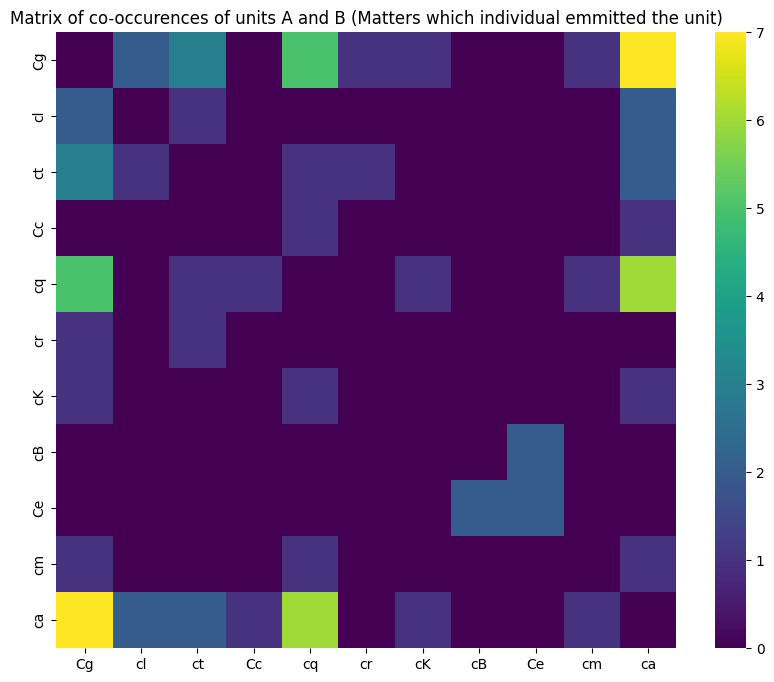

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(units_matrix, cmap='viridis')
plt.title("Matrix of co-occurences of units A and B (Matters which individual emmitted the unit)")
plt.show()


In [195]:
output = "Outputs/matrix_units_matters_emitter.xlsx"


if os.path.exists(output):
  os.remove(output)

units_matrix.to_excel(output)

# Count how many sequences an individual is

In [196]:
# Oh we would also need to count the number of sequences in wich each individual is
csv_file_path = "Outputs/no_metaunits_all_files_output.csv"


max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names).drop(0)

In [199]:
individual_appereances = dict()
for indiv in individuals:
  individual_appereances[indiv] = 0

for _, row in sequence_df.iterrows():
  focal = unidecode(row['File name'].split("_")[1].split(".")[0])
  individual = unidecode(row['File name'].split("_")[1].split(".")[1])
  individual_appereances[focal] += 1
  individual_appereances[individual] += 1

individual_appereances_df = pd.DataFrame(individual_appereances.items(), columns=['Individual', 'Number of sequences'])

In [ ]:
if os.path.exists("Outputs/individual_appereances.xlsx"):
  os.remove("Outputs/individual_appereances.xlsx")

individual_appereances_df.to_excel("Outputs/individual_appereances.xlsx", index=False)